# Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Diccionario

In [2]:
import pandas as pd

# Leer el archivo Excel
df_diccionarios = pd.read_excel('./files/envi_2020_fd.xlsx')

# Inicializar el diccionario para almacenar las secciones y preguntas
diccionario_secciones = {}
seccion_actual = None

# Recorrer el DataFrame fila por fila
for index, row in df_diccionarios.iterrows():
    # Identificar las filas que contienen 'SECCIÓN'
    if isinstance(row[1], str) and 'SECCIÓN' in row[1]:
        seccion_actual = row[1].strip()
        diccionario_secciones[seccion_actual] = []
    # Si estamos dentro de una sección, añadir las preguntas y nemónicos, excluyendo los encabezados y [1] y [2]
    elif seccion_actual and isinstance(row[1], str) and row[1].strip() not in ["Pregunta", "Nemónico", "[1]", "[2]"]:
        pregunta = row[1].strip() if isinstance(row[1], str) else ''
        nemonico = row[2].strip() if isinstance(row[2], str) else ''
        if pregunta and nemonico:
            diccionario_secciones[seccion_actual].append((pregunta, nemonico))

# Guardar el diccionario en un archivo JSON
output_file = './processed_files/diccionario_secciones.json'
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(diccionario_secciones, f, ensure_ascii=False, indent=4)

print(f"El diccionario ha sido guardado en {output_file}")


El diccionario ha sido guardado en ./processed_files/diccionario_secciones.json


---

# Archivos importantes

In [3]:
# Ruta archivos
ruta = './files/envi_2020_base_de_datos_csv/Bases de datos'
# Archivos
df_TVIVIENDA = pd.read_csv(ruta + '/TVIVIENDA.csv')
df_TSDEM = pd.read_csv(ruta + '/TSDEM.csv')
df_TVIVIENDA.shape

(55147, 416)

---

# Delimitación de Nan's

In [4]:
missing_percentage = df_TVIVIENDA.isnull().mean()*100
columns_to_keep = missing_percentage[missing_percentage < 60].index

df_TVIVIENDA = df_TVIVIENDA[columns_to_keep]

# Guardar el nuevo DataFrame sin columnas con exceso de NaNs
df_TVIVIENDA.to_csv('./processed_files/TVIVIENDA_clean.csv', index=False)

---

# Entendimiento de los datos

In [7]:
df_TVIVIENDA = pd.read_csv('./processed_files/TVIVIENDA_clean.csv')

# Leer el diccionario de secciones
with open('./processed_files/diccionario_secciones.json', 'r', encoding='utf-8') as f:
    diccionario_secciones = json.load(f)

# Revisar que preguntas están en el DataFrame
preguntas = []
for seccion, preguntas_seccion in diccionario_secciones.items():
    for pregunta, nemonico in preguntas_seccion:
        if nemonico in df_TVIVIENDA.columns:
            preguntas.append((seccion, pregunta, nemonico))

# Guardar las preguntas en un archivo CSV
df_preguntas = pd.DataFrame(preguntas, columns=['Sección', 'Pregunta', 'Nemónico'])
df_preguntas.to_excel('./processed_files/preguntas.xlsx', index=False)


---

# Análisis topológico

Betti numbers: [1, 0, 0, 0]


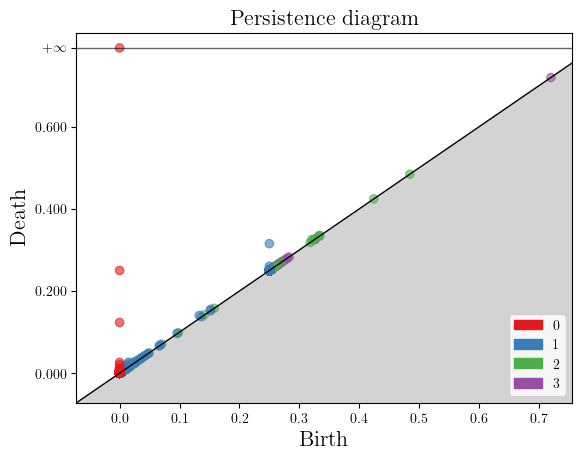

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import plotly.graph_objects as go
import gudhi as gd

# Cargar los datos
data = pd.read_csv('./processed_files/TVIVIENDA_clean.csv')

variables_materiales = ['P4_4', 'P4_5', 'P4_6']
variables_espacio = ['P4_10', 'P4_10A']
variables_servicios = ['P4_14', 'P4_15']
variables_antiguedad = ['P4_19_1', 'P5_13_2', 'P5_13_3', 'P5_25_1']
variables_dimensiones = ['P4_20_1', 'P4_21_1']
variables_satisfaccion = ['P6_8', 'P6_11']
variables_tenencia = ['P5_1', 'P5_8']
variables = variables_antiguedad
selected_data = data[variables].copy()

# Limpieza de datos: Imputar valores faltantes con la moda para datos categóricos
for column in selected_data.columns:
    selected_data[column].fillna(selected_data[column].mode()[0], inplace=True)


# Convertir datos categóricos a codificación numérica
selected_data = pd.get_dummies(selected_data)

# Convertir datos categóricos a numéricos
le = LabelEncoder()
for column in selected_data.columns:
    selected_data[column] = le.fit_transform(selected_data[column])

# Normalizar los datos
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(selected_data)
# Utilizar AlphaComplex para construir el complejo simplicial
alpha_complex = gd.AlphaComplex(points=data_normalized)
simplex_tree = alpha_complex.create_simplex_tree()
persistence_diagram = simplex_tree.persistence()
# Visualizar el diagrama de persistencia
gd.plot_persistence_diagram(persistence_diagram)
# Obtener Betti numbers
betti_numbers = simplex_tree.persistent_betti_numbers(0, np.inf)
print("Betti numbers:", betti_numbers)

# Extraer los triángulos del esqueleto
triangles = np.array([s[0] for s in simplex_tree.get_skeleton(2) if len(s[0]) == 3])

# Crear un array de puntos para los triángulos
points_array = data_normalized[np.unique(triangles)]
X, Y, Z = points_array[:, 0], points_array[:, 1], points_array[:, 2]

# Obtener triángulos como índices relativos a los puntos únicos usados
tri_indices = {idx: i for i, idx in enumerate(np.unique(triangles))}
triangles_indices = np.array([[tri_indices[idx] for idx in tri] for tri in triangles])

# Graficar el complejo
fig = go.Figure(data=[
    go.Mesh3d(
        x=X,
        y=Y,
        z=Z,
        i=triangles_indices[:, 0],
        j=triangles_indices[:, 1],
        k=triangles_indices[:, 2],
        color='blue',
        opacity=0.05
    )
])

fig.update_layout(
    width=800,
    height=800,
    scene=dict(
        xaxis=dict(nticks=4, range=[-1,1]),
        yaxis=dict(nticks=4, range=[-1,1]),
        zaxis=dict(nticks=4, range=[-1,1])
    )
)
fig.show()

---